<a href="https://colab.research.google.com/github/daminnock/NeMo-r1.14.0/blob/main/DAM-tools/Improve_clips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frequency Analysis

Analyze the frequency spectrum of a "breath" clip and compare it with a "speaking" clip. We'll find that the the "speaking" clip has more relevant components in low frequency. So apply a filter to distinguish when is voice and when is something else (like breathing or silence) is going to be useful.

If there is an other noisse in the background, you can apply this same approuch by replacing the Breath clip with a clip of the noisse.

Breath clip


Speaking clip


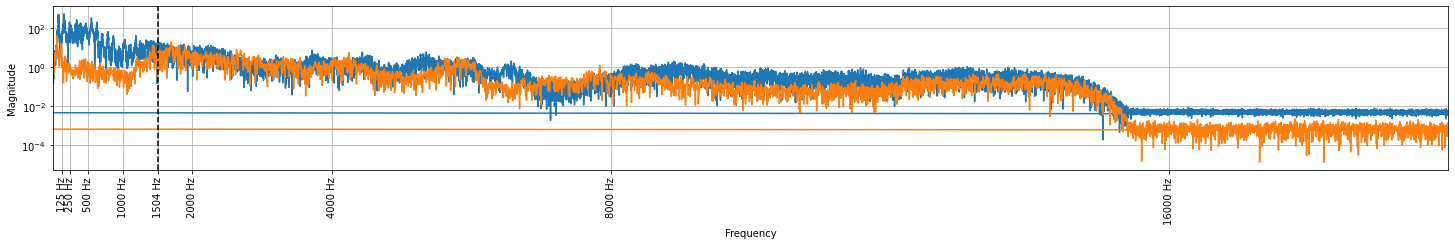

In [ ]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
from scipy import signal

# Load audio file
x, fs = sf.read('/content/sample.wav')
plt.rcParams["figure.figsize"] = (25,3)


# In this example we select one clip with breath and an other clip with voice
print('Breath clip')
x2=x[135000:150200]
ipd.display(ipd.Audio(x2, rate=fs))

x3=x[90000:130000]
print('Speaking clip')
ipd.display(ipd.Audio(x3, rate=fs))

# Apply Hamming window and calculate fft
window = np.hamming(len(x3))
x_windowed = x3 * window
x_fft = fft(x_windowed)

# Obtain corresponding frequency values
freq = np.fft.fftfreq(len(x3), d=1/44100)

# Plot spectrum
plt.plot(freq, np.abs(x_fft))


# Apply Hamming window and calculate fft
window = np.hamming(len(x2))
x2_windowed = x2 * window
x2_fft = fft(x2_windowed)

# Obtain corresponding frequency values
freq = np.fft.fftfreq(len(x2), d=1/fs)

# Plot spectrum
plt.plot(freq, np.abs(x2_fft))


# Calculate cutoff frecuency

# Calculate power spectral densities
frequencies1, psd1 = signal.welch(x2, fs)
frequencies2, psd2 = signal.welch(x3, fs)

# Define a list of cutoff frequencies to try.
cutoffs = np.linspace(1,fs/8, 100) # max frequency is fs/2 (becaus of Nyquist). I define fs/8 as maximum filter frequency

# Iterate over the cutoff frequencies and calculate the ratio of the PSDs
ratios = []
for cutoff in cutoffs:
    b, a = signal.butter(4, cutoff, btype='lowpass',fs=fs)
    psd1_filt = signal.filtfilt(b, a, psd1)
    psd2_filt = signal.filtfilt(b, a, psd2)
    ratio = np.sum(psd1_filt) / np.sum(psd2_filt)
    ratios.append(ratio)

# Find the cutoff frequency that maximizes the ratio
optimal_cutoff = cutoffs[np.argmax(ratios)]

# Plot Optimal cutoff frequency
plt.axvline(x=optimal_cutoff, color='black',linestyle='dashed')

# Define x_ticks
octave_freqs = np.logspace(np.log2(125), np.log2(16000), num=8, base=2)
octave_freqs = np.sort(np.append(octave_freqs,np.round(optimal_cutoff,0)))
plt.xticks(octave_freqs, [f'{int(f)} Hz' for f in octave_freqs])
plt.xticks(rotation = 90)

# Configure plot
plt.xlim(0, 20000)
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True, which='both')

plt.show()

# Time analysis

The next code is an example to improve an audio clip that should be used as sample for a TTS. 

A good sample should have these features:
- Start with a pause.
- End with a pause.
- Do not have any long pause because that means the speech isn't fluent.

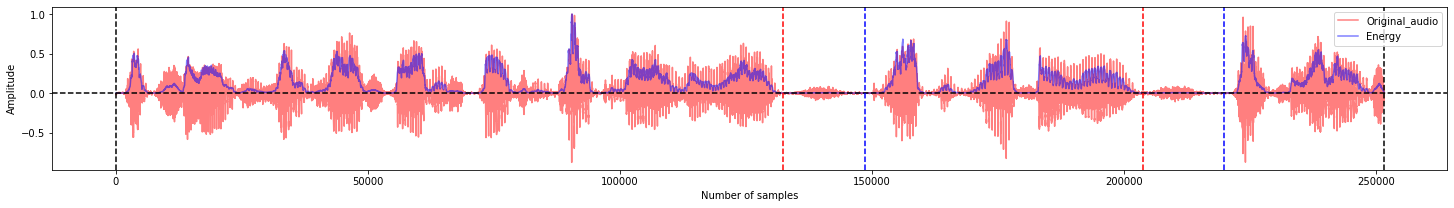

In [ ]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
from scipy import signal
plt.rcParams["figure.figsize"] = (25,3)

# Load audio file
audio_array, fs = sf.read('/content/sample.wav')

# Window length in s of "small pause". We call "small pause" a space between words in a normal speech
min_window_length_ms = 0.01
max_window_length_ms = 0.05

# Window length in s of "long pause". We call "long pause" a minimum space between words that should not exist in a normal speech
pause_length_ms = 0.2

# Windows lengths in samples
min_window_length = int(min_window_length_ms * fs)
max_window_length = int(max_window_length_ms * fs)
pause_length = int(pause_length_ms * fs)

# Window function
window = np.ones(min_window_length) / float(min_window_length)

# Convolution
convolved_audio = np.convolve(audio_array ** 2, window, "same")

# Threshold for low energy. It's compared to the mean of the convolved audio.
threshold = 0.2
threshold = np.mean(convolved_audio) * threshold

# Check if the first and last 10ms have low energy
first_10ms_low_energy = convolved_audio[: int(min_window_length_ms * fs)].mean() < threshold
last_10ms_low_energy = convolved_audio[-int(min_window_length_ms * fs):].mean() < threshold

# Adjust the boundaries of the audio if necessary
if not last_10ms_low_energy:
    last_low_energy_sample = np.where(convolved_audio < threshold)[0][-1]
    # Look for the minimum in within a window of window length
    last_low_energy_zone = np.where(convolved_audio==np.min(convolved_audio[int(last_low_energy_sample-max_window_length):last_low_energy_sample + 1]))[0][0] 
    audio_array = audio_array[: last_low_energy_zone + 1]
    convolved_audio = convolved_audio[: last_low_energy_zone + 1]

if not first_10ms_low_energy:
    first_low_energy_sample = np.where(convolved_audio < threshold)[0][0]
    # Look for the minimum in within a window of window length
    first_low_energy_zone = np.where(convolved_audio==np.min(convolved_audio[first_low_energy_sample:int(first_low_energy_sample+max_window_length)]))[0][0] 
    audio_array = audio_array[first_low_energy_zone:]
    convolved_audio = convolved_audio[first_low_energy_zone:]

# Find the low energy zones that are at least pause_length_ms long
not_pause_frames = np.where(convolved_audio > threshold)[0]
pause_durations = np.diff(not_pause_frames)
disfluent_segments = np.where(pause_durations > pause_length)[0]

plt.plot(audio_array,color='red',alpha=0.5,label='Original_audio')
plt.plot(convolved_audio/np.max(convolved_audio),color='blue',alpha=0.5,label='Energy')
plt.axhline(threshold, color='black',linestyle='dashed')

plt.xlabel("Number of samples")
plt.ylabel("Amplitude")

splitted_audio=[]
start = 0
for i in disfluent_segments:
    # End in a low energy frame
    end = not_pause_frames[i]
    end = np.where(convolved_audio==np.min(convolved_audio[end+1:int(end + max_window_length + 1)]))[0][0] 
    splitted_audio.append(audio_array[start:end + 1])
    # Start in a low energy frame
    start = not_pause_frames[i+1] - max_window_length # Prepare for next segment
    start = np.where(convolved_audio==np.min(convolved_audio[int(start-max_window_length):start]))[0][0] 
    plt.axvline(end, color='red',linestyle='dashed')
    plt.axvline(start, color='blue',linestyle='dashed')
splitted_audio.append(audio_array[start:-1])
plt.axvline(last_low_energy_zone, color='black',linestyle='dashed')
plt.axvline(0, color='black',linestyle='dashed')

# Show audios
for audio in splitted_audio:
    ipd.display(ipd.Audio(audio, rate=fs))

plt.legend()
plt.show()